# Import Library

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pathlib
import numpy as np
import numpy
import os
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import sklearn.metrics as metrics

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB3, ResNet50
from tensorflow.keras.applications import EfficientNetB3, VGG16
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Import Helper Functions

In [5]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Confusion matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [6]:
def predict_class_label_number(dataset, model):
  """Runs inference and returns predictions as class label numbers."""
  rev_label_names = {l: i for i, l in enumerate(class_names)}
  return [
      rev_label_names[o[0][0]]
      for o in model.predict_top_k(dataset, batch_size=128)
  ]

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
              annot=True, fmt='g', cmap='Blues')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

# Load Data

In [7]:
# file path in drive
train_dir = pathlib.Path("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train")
test_dir = pathlib.Path("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/test")
val_dir = pathlib.Path("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation")

# Define the class names
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(len(class_names))
print(class_names)

list_train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
list_test_ds = tf.data.Dataset.list_files(str(test_dir/'*/*'))
list_val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))

for f in list_train_ds.take(5):
  print(f.numpy())

3
['partly brown' 'partly purple' 'well fermented']
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly purple/CROP12_20_otsu.jpg'
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly purple/CROP33_28_otsu.jpg'
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/well fermented/CROP20_53_otsu.jpg'
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/well fermented/CROP11_26_otsu.jpg'
b'/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/well fermented/CROP11_71_otsu.jpg'


In [8]:
# cek jumlah gambar data train
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# cek jumlah gambar data validation
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# cek jumlah gambar data test
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Kakao/(4) train test validation/otsu/test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train'.
There are 0 directories and 160 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/well fermented'.
There are 0 directories and 160 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly brown'.
There are 0 directories and 160 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/train/partly purple'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation/partly brown'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation/well fermented'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Kakao/(4) train test validation/otsu/validation/partly purple'.
There are 3 dir

In [9]:
# size of input image
img_size= 224
input_shape = (img_size, img_size, 3) # 224x224 pixel with 3 channel (RGB)

# takes a file path as input
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

# takes an image in the form of raw image data (encoded in JPEG format) as input
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    return img

# process a file path that points to an image file
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
# optimize the dataset processing
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, batch_size, shuffle=True):
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    # Shuffle the data if True or False
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    # Batch all dataset
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [11]:
# Data augmentation
data_augmentation = Sequential([
    preprocessing.RandomCrop(height=img_size, width=img_size),
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomContrast((0.2, 0.2)),
    preprocessing.RandomZoom((-0.2, 0)),
    preprocessing.RandomRotation(0.2)
])

# train the model

## ResNet50

*   Batch size: 32
*   Learning rate: 0.0001
*   epoch: 200
*   optimizer: Adam


In [12]:
batch_size = 32 # input batch size

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

# input CNN architecture
baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

# inputting data
inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)

# name the model
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200 # input epoch
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# input loss function, optimizer, metrics
model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.7354

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 145s 2s/step - loss: 0.5870 - accuracy: 0.7354 - val_loss: 1.9779 - val_accuracy: 0.4167
Epoch 2/200
15/15 [==============================] - 9s 453ms/step - loss: 0.0470 - accuracy: 0.9917 - val_loss: 0.7575 - val_accuracy: 0.6833
Epoch 3/200
15/15 [==============================] - 9s 524ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.5948 - val_accuracy: 0.7667
Epoch 4/200
15/15 [==============================] - 7s 369ms/step - loss: 0.0266 - accuracy: 0.9937 - val_loss: 1.3781 - val_accuracy: 0.5833
Epoch 5/200
15/15 [==============================] - 8s 453ms/step - loss: 0.0183 - accuracy: 0.9979 - val_loss: 0.3641 - val_accuracy: 0.8167
Epoch 6/200
15/15 [==============================] - 7s 357ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.5789 - val_accuracy: 0.8000
Epoch 7/200
15/15 [==============================] - 7s 359ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.3784 - val_accuracy: 0.8667
Epoch 8/200


In [13]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 11s 5s/step - loss: 0.4718 - accuracy: 0.8833
Loss : 0.4718042314052582
Accuracy : 0.8833333253860474


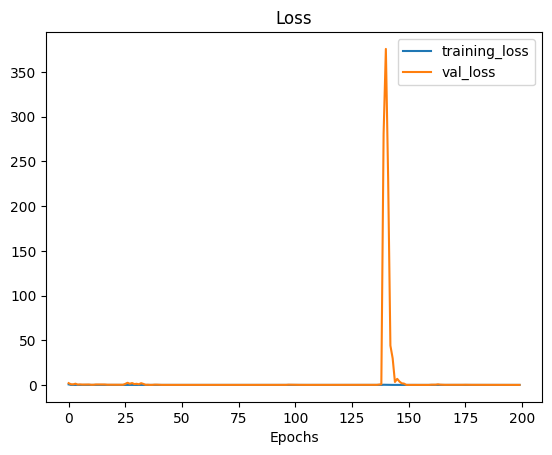

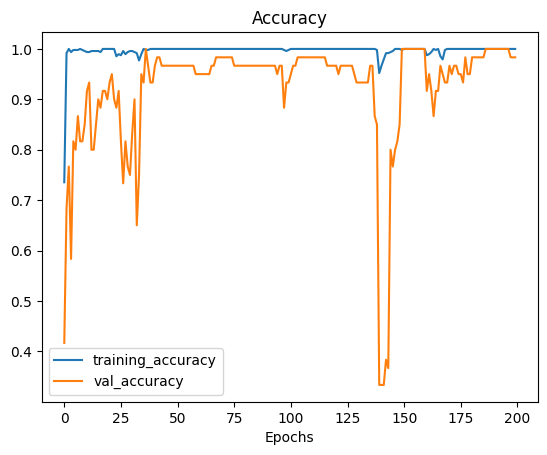

In [14]:
plot_loss_curves(history_ResNet50_6)

In [21]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_ResNet50_6.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 1s/step


In [22]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

In [24]:
import plotly.graph_objs as go
import plotly.figure_factory as ff

z = confusion_mtx[::-1]
x = class_names
y =  x[::-1].copy()
heatmap = go.Heatmap(z=z, x=x, y=y, colorscale='Blues')

annotations = []
for i, row in enumerate(confusion_mtx.numpy().T):
    for j, value in enumerate(row):
        annotations.append(
            {
                "x": x[i],
                "y": x[j],
                "font": {"color": "black", "size" : 30},
                "text": str(value),
                "xref": "x1",
                "yref": "y1",
                "showarrow": False
            }
        )
layout = {
      "title": 'a',
      "xaxis": {"title": "Predictions"},
      "yaxis": {"title": "Labels"},
      "annotations": annotations
  }
fig = go.Figure(data=[heatmap], layout=layout)
fig.update_yaxes(tickangle=-90)
fig.update_layout(
    width=800, height=800,
    font=dict(
      family="Arial", size=20,),
)
# show the figure
fig.show()

In [25]:
# path to save model
path = r"/content/drive/MyDrive/Latihan CNN/save model"
os.chdir(path)

# save model
model_ResNet50_6.save("Model CNN ResNet50_6")

# Visualize loss plot better

In [19]:
# Plot the validation and training data separately
def plot_loss_curves_2(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.ylim([0,1]) # setting y value
  plt.legend()

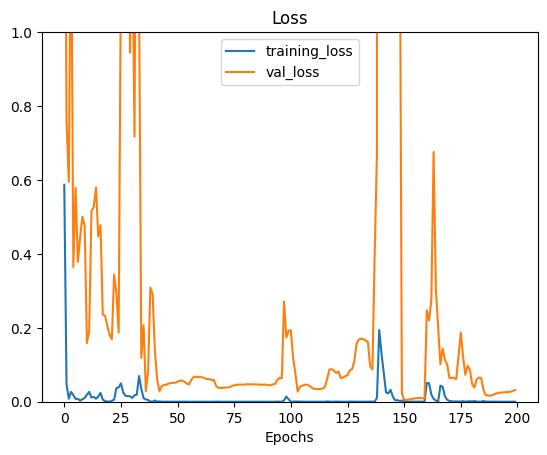

In [20]:
# Check model's performance history training on augmented data
plot_loss_curves_2(history_ResNet50_6)

# Load Saved Model

## ResNet50

In [26]:
from tensorflow.keras.models import load_model

# load model
model = load_model('/content/drive/MyDrive/Latihan CNN/save model/Model CNN ResNet50_6')

In [27]:
batch_size = 32
test_data = prepare(list_test_ds, batch_size, shuffle=False)

In [28]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_data:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 1s 966ms/step


In [29]:
confusion_mtx = tf.math.confusion_matrix(
    correct_labels, predicted_labels,
    num_classes=len(class_names))

In [31]:
import plotly.graph_objs as go
import plotly.figure_factory as ff

z = confusion_mtx[::-1]
x = class_names
y =  x[::-1].copy()
heatmap = go.Heatmap(z=z, x=x, y=y, colorscale='Blues')

annotations = []
for i, row in enumerate(confusion_mtx.numpy().T):
    for j, value in enumerate(row):
        annotations.append(
            {
                "x": x[i],
                "y": x[j],
                "font": {"color": "black", "size" : 35},
                "text": str(value),
                "xref": "x1",
                "yref": "y1",
                "showarrow": False
            }
        )
layout = {
      "title": 'a',
      "xaxis": {"title": "Predictions"},
      "yaxis": {"title": "Labels"},
      "annotations": annotations
  }
fig = go.Figure(data=[heatmap], layout=layout)
fig.update_yaxes(tickangle=-90)
fig.update_layout(
    width=800, height=800,
    font=dict(
      family="Arial", size=30,),
)
# show the figure
fig.show()

In [32]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 1s 122ms/step - loss: 0.4718 - accuracy: 0.8833
Loss : 0.4718039929866791
Accuracy : 0.8833333253860474


# Experimenting

## VGG16

VGG16
*   Learning Rate = 0.001

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

# input CNN architecture
baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)

# name model
model_VGG16_7 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_7)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_7 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_7.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])

history_VGG16_7 = model_VGG16_7.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/200
8/8 [==============================] - 65s 4s/step - loss: 33.3424 - accuracy: 0.3688 - val_loss: 1.4054 - val_accuracy: 0.3333
Epoch 2/200
8/8 [==============================] - 9s 870ms/step - loss: 1.3708 - accuracy: 0.3250 - val_loss: 1.1734 - val_accuracy: 0.3333
Epoch 3/200
8/8 [==============================] - 8s 817ms/step - loss: 1.1003 - accuracy: 0.3479 - val_loss: 1.1399 - val_accuracy: 0.3333
Epoch 4/200
8/8 [==============================] - 8s 832ms/step - loss: 1.1101 - accuracy: 0.3417 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 5/200
8/8 [==============================] - 8s 800ms/step - loss: 1.0984 - accuracy: 0.3708 - val_loss: 1.0985 - val_accuracy: 0.2500
Epoch 6/200
8/8 [==============================] - 7s 782ms/step - loss: 1.0983 - accuracy: 0.3562 - val_loss: 1.0988 - val_accuracy: 0.3167
Epoch 7/200
8/8 [==============================] - 8s 802ms/step - loss: 1.0983 - accuracy

In [ ]:
# data test
loss, accuracy = model_VGG16_7.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 20s 20s/step - loss: 0.8922 - accuracy: 0.8000
Loss : 0.8922046422958374
Accuracy : 0.800000011920929


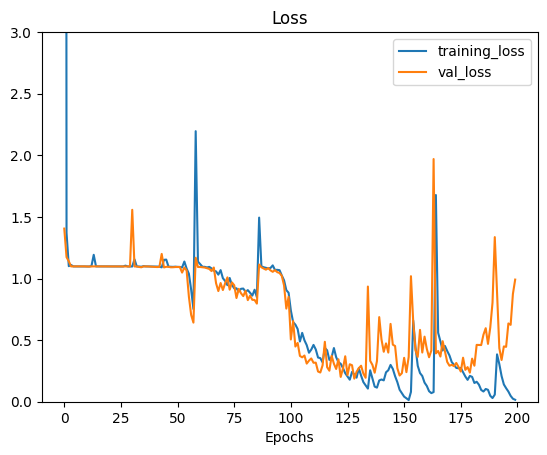

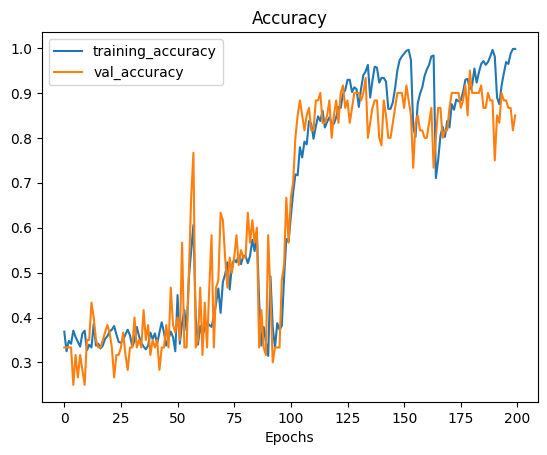

In [ ]:
plot_loss_curves(history_VGG16_7)

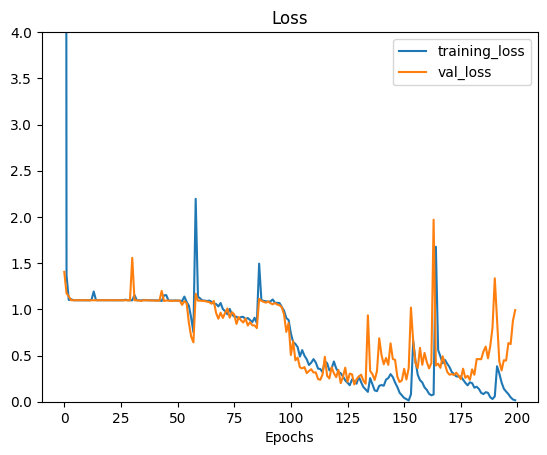

In [ ]:
plot_loss_curves_2(history_VGG16_7)

VGG16
*   Learning Rate = 0.0001

In [ ]:
batch_size = 64

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

img_size= 224
input_shape = (img_size, img_size, 3)
dropout_rate = 0.3

baseline_model = VGG16(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_VGG16_7 = baseline_model(inputs) # isi augmented kalo pake augmentasi, kalo ga isi inputs
pooling = layers.GlobalAveragePooling2D()(model_VGG16_7)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_VGG16_7 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model_VGG16_7.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])

history_VGG16_7 = model_VGG16_7.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/200
8/8 [==============================] - 60s 4s/step - loss: 1.9130 - accuracy: 0.3604 - val_loss: 1.0936 - val_accuracy: 0.3667
Epoch 2/200
8/8 [==============================] - 9s 882ms/step - loss: 1.1073 - accuracy: 0.3521 - val_loss: 1.0890 - val_accuracy: 0.3333
Epoch 3/200
8/8 [==============================] - 8s 904ms/step - loss: 1.0983 - accuracy: 0.3500 - val_loss: 1.0824 - val_accuracy: 0.4167
Epoch 4/200
8/8 [==============================] - 8s 864ms/step - loss: 1.0880 - accuracy: 0.3583 - val_loss: 1.0678 - val_accuracy: 0.3667
Epoch 5/200
8/8 [==============================] - 8s 804ms/step - loss: 1.0615 - accuracy: 0.3500 - val_loss: 1.1818 - val_accuracy: 0.3333
Epoch 6/200
8/8 [==============================] - 8s 826ms/step - loss: 1.1260 - accuracy: 0.3250 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 7/200
8/8 [==============================] - 9s 790ms/step - loss: 1.0921 - accuracy:

In [ ]:
# data test
loss, accuracy = model_VGG16_7.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

1/1 [==============================] - 1s 578ms/step - loss: 0.7925 - accuracy: 0.9000
Loss : 0.792510986328125
Accuracy : 0.8999999761581421


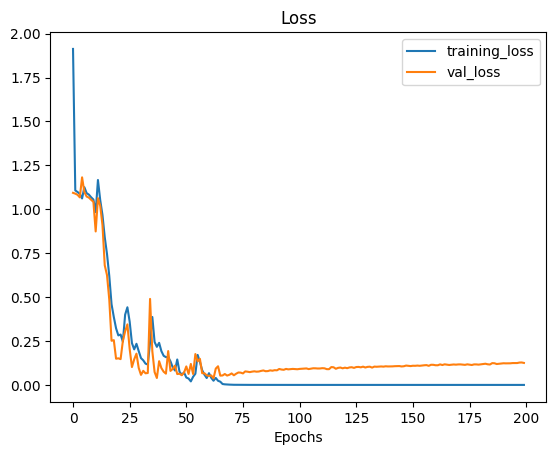

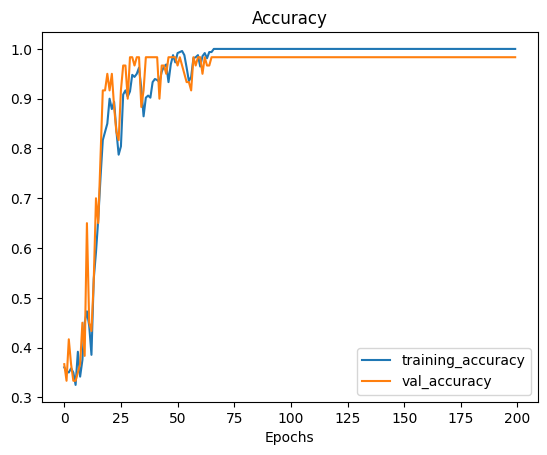

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves(history_VGG16_7)

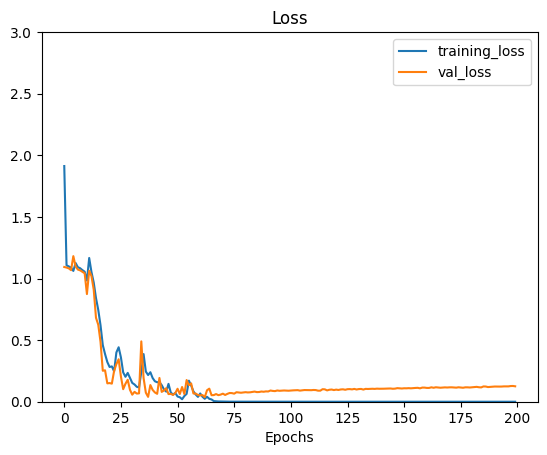

In [ ]:
# Check model's performance history training on augmented data
plot_loss_curves_2(history_VGG16_7)

## ResNet50

ResNet50
*   Learning Rate = 0.0001

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 55s 1s/step - loss: 0.6871 - accuracy: 0.6958 - val_loss: 1.1421 - val_accuracy: 0.4000
Epoch 2/200
15/15 [==============================] - 7s 366ms/step - loss: 0.0527 - accuracy: 0.9875 - val_loss: 1.2766 - val_accuracy: 0.5667
Epoch 3/200
15/15 [==============================] - 7s 360ms/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 1.8327 - val_accuracy: 0.4667
Epoch 4/200
15/15 [==============================] - 7s 380ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 1.8775 - val_accuracy: 0.4833
Epoch 5/200
15/15 [==============================] - 7s 360ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.2763 - val_accuracy: 0.6000
Epoch 6/200
15/15 [==============================] - 9s 499ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.1216 - val_accuracy: 0.6667
Epoch 7/200
15/15 [==============================] - 11s 706ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.0315 - val_accuracy: 0.7333


In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 101ms/step - loss: 0.7624 - accuracy: 0.8000
Loss : 0.7624051570892334
Accuracy : 0.800000011920929


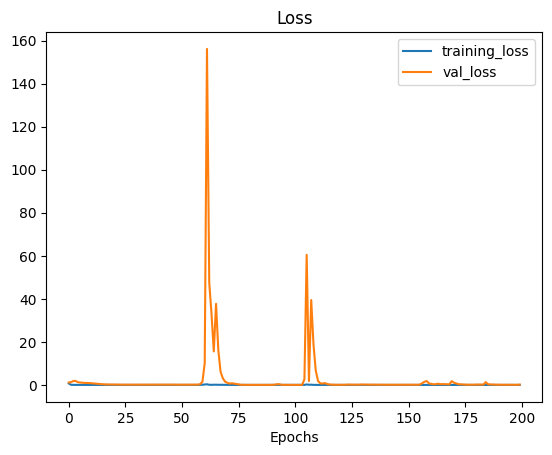

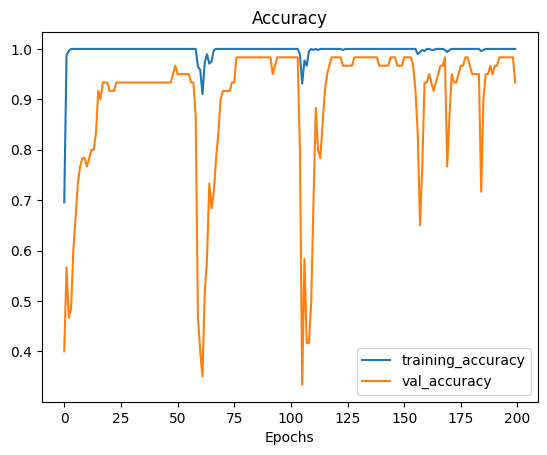

In [ ]:
plot_loss_curves(history_ResNet50_6)

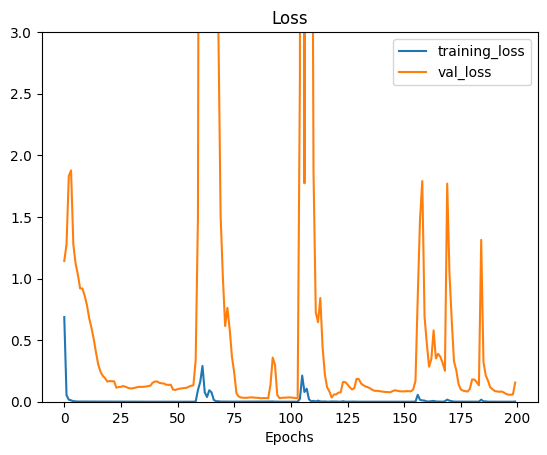

In [ ]:
plot_loss_curves_2(history_ResNet50_6)

ResNet50
*   Learning Rate = 0.001



In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 74s 786ms/step - loss: 0.7893 - accuracy: 0.7292 - val_loss: 1100.2429 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 7s 334ms/step - loss: 0.3454 - accuracy: 0.8750 - val_loss: 2497.1399 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 10s 607ms/step - loss: 0.2719 - accuracy: 0.9167 - val_loss: 391.6460 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 10s 601ms/step - loss: 0.1660 - accuracy: 0.9312 - val_loss: 380.9627 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 11s 613ms/step - loss: 0.1162 - accuracy: 0.9625 - val_loss: 115.6835 - val_accuracy: 0.3833
Epoch 6/200
15/15 [==============================] - 7s 358ms/step - loss: 0.1513 - accuracy: 0.9479 - val_loss: 125.0527 - val_accuracy: 0.3333
Epoch 7/200
15/15 [==============================] - 12s 714ms/step - loss: 0.0493 - accuracy: 0.9875 - val_loss: 16.2184 - 

In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 118ms/step - loss: 0.7998 - accuracy: 0.7500
Loss : 0.7998490929603577
Accuracy : 0.75


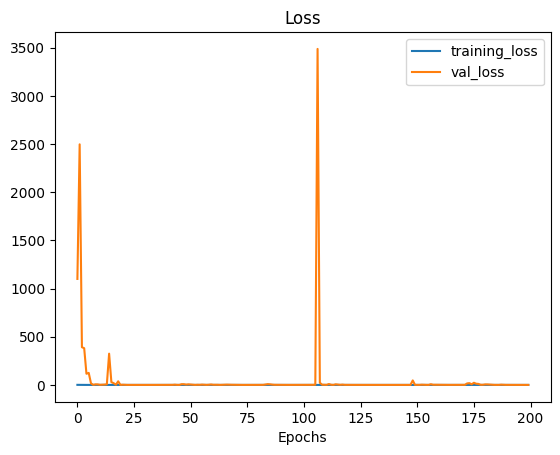

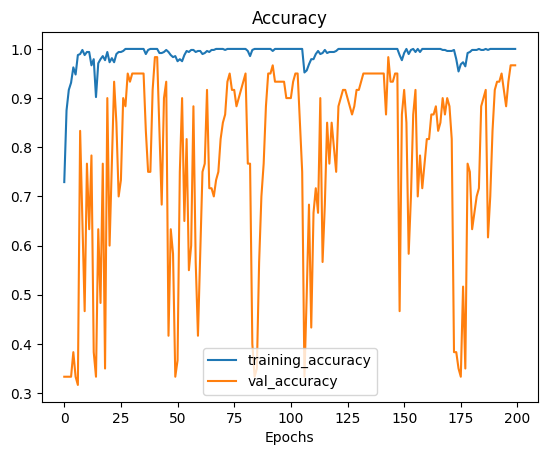

In [ ]:
plot_loss_curves(history_ResNet50_6)

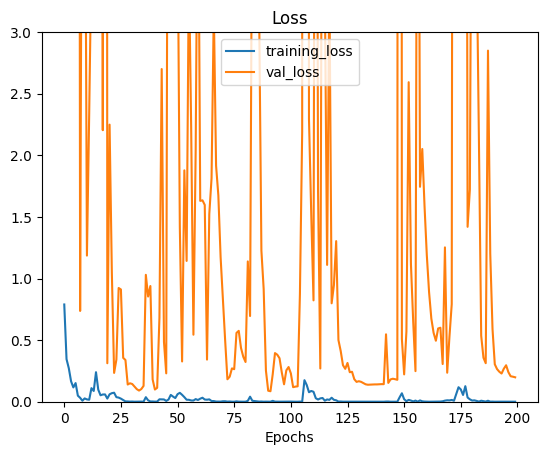

In [ ]:
plot_loss_curves_2(history_ResNet50_6)

ResNet50
*   Learning Rate = 0.01

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.01), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/200
15/15 [==============================] - 242s 2s/step - loss: 3.0469 - accuracy: 0.4125 - val_loss: 796798140865839104.0000 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 8s 428ms/step - loss: 1.0795 - accuracy: 0.6708 - val_loss: 745872476340224.0000 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 7s 417ms/step - loss: 0.6746 - accuracy: 0.8333 - val_loss: 1144947212288.0000 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 7s 420ms/step - loss: 0.6304 - accuracy: 0.8438 - val_loss: 1572365440.0000 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 8s 419ms/step - loss: 0.5254 - accuracy: 0.8375 - val_loss: 12928314.0000 - val_accuracy: 0.3333
Epoch 6/200
15/15 [==============================] - 8s 421ms/step - loss: 0.5131 - accuracy: 0.8562 - val_loss: 507997.6250 - val_accuracy: 0.3333
Epoch 7/200
15

In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 25s 11s/step - loss: 0.9421 - accuracy: 0.8167
Loss : 0.9421356320381165
Accuracy : 0.8166666626930237


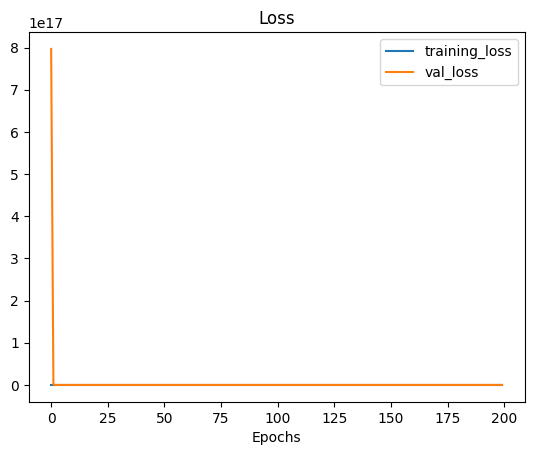

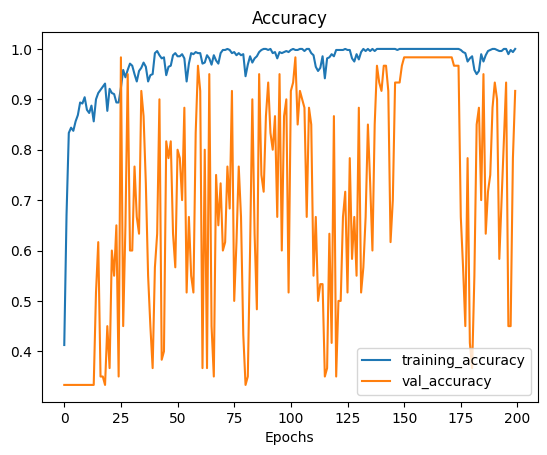

In [ ]:
plot_loss_curves(history_ResNet50_6)

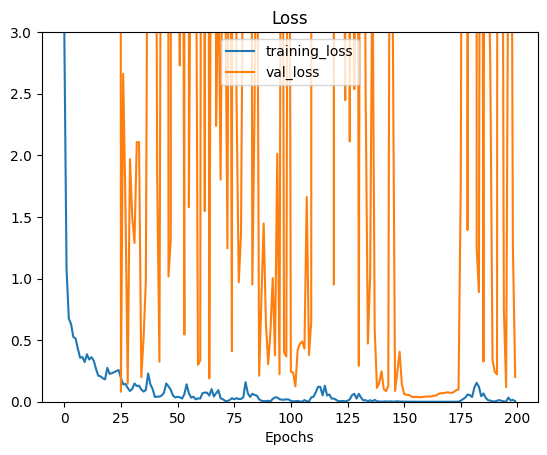

In [ ]:
plot_loss_curves_2(history_ResNet50_6)

ResNet50
*   Learning Rate = 0.1

In [ ]:
batch_size = 32

train_data = prepare(list_train_ds, batch_size)
val_data = prepare(list_val_ds, batch_size)
test_data = prepare(list_test_ds, batch_size, shuffle=False)

dropout_rate = 0.3

baseline_model = ResNet50(include_top=False, input_shape = input_shape)
baseline_model.trainable = True

inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
model_ResNet50_6 = baseline_model(inputs)
pooling = layers.GlobalAveragePooling2D()(model_ResNet50_6)
outputs = layers.Dense(len(class_names), activation='softmax')(pooling)
model_ResNet50_6 = Model(inputs=inputs, outputs=outputs)

epochs = 200
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model_ResNet50_6.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.1), metrics=["accuracy"])
history_ResNet50_6 = model_ResNet50_6.fit(train_data, epochs = epochs,
                    validation_data = val_data, callbacks = [callbacks])

Epoch 1/200
15/15 [==============================] - 47s 561ms/step - loss: 8.7000 - accuracy: 0.4208 - val_loss: 666239506183665684112736256.0000 - val_accuracy: 0.3333
Epoch 2/200
15/15 [==============================] - 12s 735ms/step - loss: 0.6416 - accuracy: 0.7333 - val_loss: 125459679798099968.0000 - val_accuracy: 0.3333
Epoch 3/200
15/15 [==============================] - 10s 625ms/step - loss: 0.5274 - accuracy: 0.7667 - val_loss: 1139449135104.0000 - val_accuracy: 0.3333
Epoch 4/200
15/15 [==============================] - 11s 637ms/step - loss: 0.4974 - accuracy: 0.7771 - val_loss: 1965217408.0000 - val_accuracy: 0.3333
Epoch 5/200
15/15 [==============================] - 11s 660ms/step - loss: 0.4865 - accuracy: 0.8167 - val_loss: 36044008.0000 - val_accuracy: 0.3333
Epoch 6/200
15/15 [==============================] - 10s 627ms/step - loss: 0.4228 - accuracy: 0.8083 - val_loss: 3818290.2500 - val_accuracy: 0.3333
Epoch 7/200
15/15 [==============================] - 11s 67

In [ ]:
# data test
loss, accuracy = model_ResNet50_6.evaluate(test_data)
print("Loss :", loss)
print("Accuracy :", accuracy)

2/2 [==============================] - 0s 151ms/step - loss: 2.7845 - accuracy: 0.7167
Loss : 2.7845075130462646
Accuracy : 0.7166666388511658


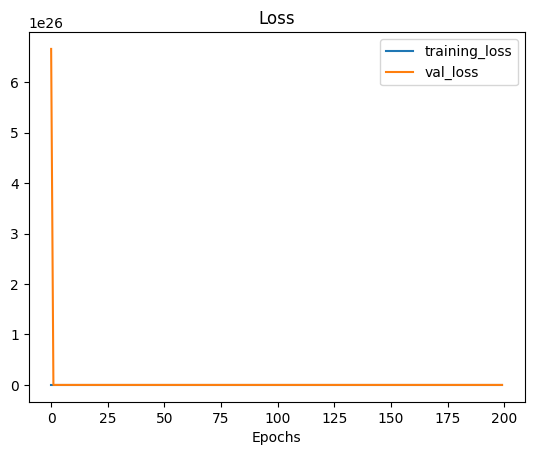

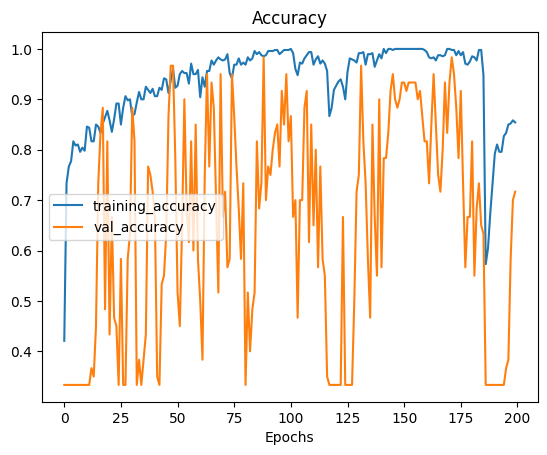

In [ ]:
plot_loss_curves(history_ResNet50_6)

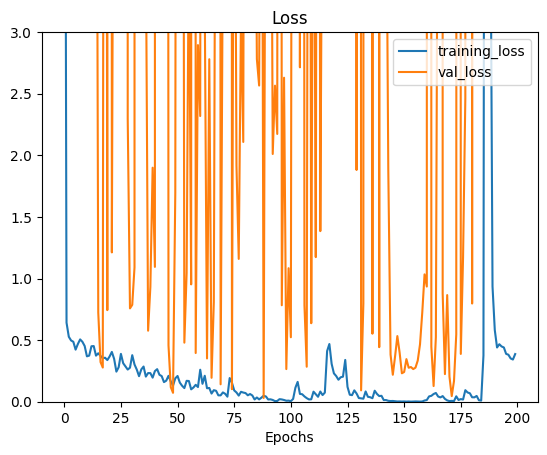

In [ ]:
plot_loss_curves_2(history_ResNet50_6)